In [1]:
import numpy as np
import pandas as pd
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import os
from rubin_sim.utils import uniformSphere
import rubin_sim.maf.slicers as slicers
import glob
from rubin_sim.photUtils import Dust_values
from rubin_sim.data import get_data_dir

import rubin_sim.maf as maf
import rubin_sim.maf.db as db
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.data import get_baseline

In [2]:
__all__ = ["Tde_lc", "TdePopMetric", "generateTdePopSlicer"]


class Tde_lc(object):
    """
    Read in some TDE lightcurves
    Parameters
    ----------
    file_list : list of str (None)
        List of file paths to load.
    """

    def __init__(self, file_list=None):

        if file_list is None:
            sims_maf_contrib_dir = get_data_dir()
            #file_list = glob.glob(os.path.join(sims_maf_contrib_dir, "maf/tde/*.dat"))
            file_list = glob.glob(os.path.join('events/*.dat'))

        lcs = []
        for filename in file_list:
            lcs.append(
                np.genfromtxt(
                    filename, dtype=[("ph", "f8"), ("mag", "f8"), ("filter", "U1")]
                )
            )

        # Let's organize the data in to a list of dicts for easy lookup
        self.data = []
        filternames = "ugrizy"
        for lc in lcs:
            new_dict = {}
            for filtername in filternames:
                infilt = np.where(lc["filter"] == filtername)
                new_dict[filtername] = lc[infilt]
            self.data.append(new_dict)

    def interp(self, t, filtername, lc_indx=0):
        """
        t : array of floats
            The times to interpolate the light curve to.
        filtername : str
            The filter. one of ugrizy
        lc_index : int (0)
            Which file to use.
        """

        result = np.interp(
            t,
            self.data[lc_indx][filtername]["ph"],
            self.data[lc_indx][filtername]["mag"],
            left=99,
            right=99,
        )
        return result


class TdePopMetric(metrics.BaseMetric):
    def __init__(
        self,
        metricName="TDEsPopMetric",
        mjdCol="observationStartMJD",
        m5Col="fiveSigmaDepth",
        filterCol="filter",
        nightCol="night",
        ptsNeeded=2,
        file_list=None,
        mjd0=59853.5,
        **kwargs
    ):
        maps = ["DustMap"]
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded

        self.lightcurves = Tde_lc(file_list=file_list)
        self.mjd0 = mjd0

        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1

        cols = [self.mjdCol, self.m5Col, self.filterCol, self.nightCol]
        super(TdePopMetric, self).__init__(
            col=cols,
            units="Detected, 0 or 1",
            metricName=metricName,
            maps=maps,
            **kwargs
        )

    def _pre_peak_detect(self, dataSlice, slicePoint, mags, t):
        """
        Simple detection criteria
        """
        result = 0
        # Simple alert criteria. Could make more in depth, or use reduce functions
        # to have multiple criteria checked.
        pre_peak_detected = np.where((t < 0) & (mags < dataSlice[self.m5Col]))[0]

        if pre_peak_detected.size > self.ptsNeeded:
            result = 1

        return result

    def _some_color_detect(self, dataSlice, slicePoint, mags, t):
        result = 1
        # 1 detection pre peak
        pre_peak_detected = np.where((t < -10) & (mags < dataSlice[self.m5Col]))[0]
        if np.size(pre_peak_detected) < 1:
            return 0

        # At least 3 filters within 10 days of peak
        around_peak = np.where((np.abs(t) < 5) & (mags < dataSlice[self.m5Col]))[0]
        if np.size(np.unique(dataSlice[self.filterCol][around_peak])) < 3:
            return 0

        # At least 2 bands after peak
        post_peak = np.where((t > 10) & (t < 30) & (mags < dataSlice[self.m5Col]))[0]
        if np.size(np.unique(dataSlice[self.filterCol][post_peak])) < 2:
            return 0

        return result

    def _some_color_pu_detect(self, dataSlice, slicePoint, mags, t):
        result = 1
        # 1 detection pre peak
        pre_peak_detected = np.where((t < -10) & (mags < dataSlice[self.m5Col]))[0]
        if np.size(pre_peak_detected) < 1:
            return 0

        # 1 detection in u and any other band near peak
        around_peak = np.where((np.abs(t) < 5) & (mags < dataSlice[self.m5Col]))[0]
        filters = np.unique(dataSlice[self.filterCol][around_peak])
        if np.size(filters) < 2:
            return 0
        if "u" not in filters:
            return 0

        post_peak = np.where((t > 10) & (t < 30) & (mags < dataSlice[self.m5Col]))[0]
        filters = np.unique(dataSlice[self.filterCol][post_peak])
        if np.size(filters) < 2:
            return 0
        if "u" not in filters:
            return 0

        return result

    def run(self, dataSlice, slicePoint=None):
        result = {}
        t = dataSlice[self.mjdCol] - self.mjd0 - slicePoint["peak_time"]
        mags = np.zeros(t.size, dtype=float)

        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)
            mags[infilt] = self.lightcurves.interp(
                t[infilt], filtername, lc_indx=slicePoint["file_indx"]
            )
            # Apply dust extinction on the light curve
            mags[infilt] += self.Ax1[filtername] * slicePoint["ebv"]

        result["pre_peak"] = self._pre_peak_detect(dataSlice, slicePoint, mags, t)
        result["some_color"] = self._some_color_detect(dataSlice, slicePoint, mags, t)
        result["some_color_pu"] = self._some_color_pu_detect(dataSlice, slicePoint, mags, t)
        
        file_list = glob.glob(os.path.join('events/*.dat'))
        
        # The following saves the simulated light curves into a separate directory. The
        # prepeak ones are the most simple ones, with at least 2 detections before peak.
        # One can also output more sophisticated light curves, which satisfy the some_color
        # and/or some_color_pu requirements.
        
        if result["pre_peak"] == 1:
            df_out = pd.DataFrame(columns=['mjd', 'mag', 'filter', 'epoch'])
            detected_points = np.where((mags < dataSlice[self.m5Col]))[0]
            df_out['mjd'] = dataSlice[self.mjdCol][detected_points]
            df_out['mag'] = mags[detected_points]
            df_out['filter'] = dataSlice[self.filterCol][detected_points]
            df_out['epoch'] = t[detected_points]
            f_out = open('prepeak/lc_'+str(slicePoint['sid'])+'.dat', 'a')
            f_out.write('#' + file_list[slicePoint["file_indx"]][7:-23] + '\n')
            df_out.to_csv(f_out, index=False)
            f_out.close()
        """
        if result["some_color"] == 1:
            df_out = pd.DataFrame(columns=['mjd', 'mag', 'filter', 'epoch'])
            detected_points = np.where((mags < dataSlice[self.m5Col]))[0]
            df_out['mjd'] = dataSlice[self.mjdCol][detected_points]
            df_out['mag'] = mags[detected_points]
            df_out['filter'] = dataSlice[self.filterCol][detected_points]
            df_out['epoch'] = t[detected_points]
            f_out = open('some_color/lc_'+str(slicePoint['sid'])+'.dat', 'a')
            f_out.write('#' + file_list[slicePoint["file_indx"]][7:-23] + '\n')
            df_out.to_csv(f_out, index=False)
            f_out.close()
            
        if result["some_color_pu"] == 1:
            df_out = pd.DataFrame(columns=['mjd', 'mag', 'filter', 'epoch'])
            detected_points = np.where((mags < dataSlice[self.m5Col]))[0]
            df_out['mjd'] = dataSlice[self.mjdCol][detected_points]
            df_out['mag'] = mags[detected_points]
            df_out['filter'] = dataSlice[self.filterCol][detected_points]
            df_out['epoch'] = t[detected_points]
            f_out = open('some_color_pu/lc_'+str(slicePoint['sid'])+'.dat', 'a')
            f_out.write('#' + file_list[slicePoint["file_indx"]][7:-23] + '\n')
            df_out.to_csv(f_out, index=False)
            f_out.close()
        """
        return result

    def reduce_prepeak(self, metric):
        return metric["pre_peak"]

    def reduce_some_color(self, metric):
        return metric["some_color"]

    def reduce_some_color_pu(self, metric):
        return metric["some_color_pu"]
 
        
        


def generateTdePopSlicer(t_start=1, t_end=3652, n_events=10000, seed=42, n_files=7):
    """Generate a population of TDE events, and put the info about them into a UserPointSlicer object
    Parameters
    ----------
    t_start : float (1)
        The night to start tde events on (days)
    t_end : float (3652)
        The final night of TDE events
    n_events : int (10000)
        The number of TDE events to generate
    seed : float
        The seed passed to np.random
    n_files : int (7)
        The number of different TDE lightcurves to use
    """

    ra, dec = uniformSphere(n_events, seed=seed)
    peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)
    file_indx = np.floor(np.random.uniform(low=0, high=n_files, size=n_events)).astype(
        int
    )

    # Set up the slicer to evaluate the catalog we just made
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slicePoints["peak_time"] = peak_times
    slicer.slicePoints["file_indx"] = file_indx
    return slicer

In [4]:
# Generate the slicer which n events at random spots on WFD
# n_events defines the rate of events. Currently it is set to 10000 per 10 years or 1000 per year
slicer = generateTdePopSlicer(n_events=10000)

In [5]:
# This code simulates light curves with the current baseline strategy baseline_v2.0_10yrs.db. 
# The observing strategy can be substituted with another here. 
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)

In [6]:
metric = TdePopMetric()
# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metricName='Total detected'), 
                  maf.CountMetric(metricName='Total lightcurves in footprint'),
                  maf.CountMetric(metricName='Total lightcurves on sky', maskVal=0), 
                  maf.MeanMetric(metricName='Fraction detected in footprint'), 
                  maf.MeanMetric(maskVal=0, metricName='Fraction detected of total')]

In [7]:
bundle = maf.MetricBundle(metric, slicer, None, runName=opsim, summaryMetrics=summaryMetrics)

In [8]:
outDir = 'test_tde'
bdict = {'tde': bundle}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)
g.runAll()

Querying database observations with no constraint for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'night', 'filter', 'fiveSigmaDepth', 'rotSkyPos'].
Found 2086980 visits
Running:  ['tde']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


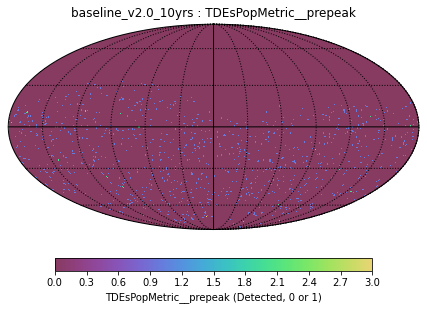

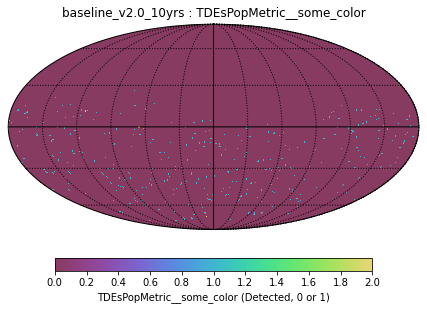

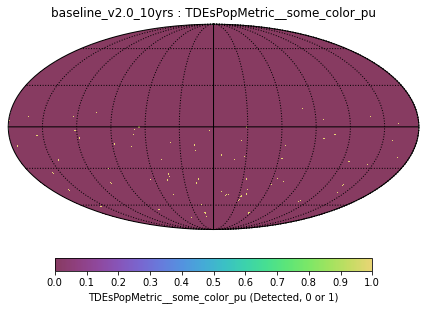

In [9]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('TDEs'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

In [10]:
for k in bdict:
    print(k, bdict[k].summaryValues)

tde {}
TDEsPopMetric__prepeak {'Total detected': 1029.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.14829226113272806, 'Fraction detected of total': 0.1029}
TDEsPopMetric__some_color {'Total detected': 352.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.05072777057212855, 'Fraction detected of total': 0.0352}
TDEsPopMetric__some_color_pu {'Total detected': 73.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.010520247874333477, 'Fraction detected of total': 0.0073}


In [11]:
pd.DataFrame([bdict[k].summaryValues for k in bdict.keys() if k.startswith('TDEs')], 
             index=[k.replace('_', ' ') for k in bdict if k.startswith('TDEs')])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
TDEsPopMetric prepeak,1029.0,6939,10000,0.148292,0.1029
TDEsPopMetric some color,352.0,6939,10000,0.050728,0.0352
TDEsPopMetric some color pu,73.0,6939,10000,0.010520,0.0073
